## Happiness Score from the [World Happiness Report](https://worldhappiness.report/)
In this notebook we will use the 2023 "World Happiness Report" dataset. This dataset is based on the yearly Gallup World Poll which surveys around 100,000 people from 130 countries. The main metric is the Cantril ladder which asks respondents to think of a ladder and their standing on it with the best possible life for them being a 10 and the worst possible life being a 0. We select the five countries with the highest variance across the years 2008 to 2022 with respect to the Cantrill Ladder Score.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


from tueplots import bundles
import tueplots
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
# Plug any of those into either the rcParams or into an rc_context:
plt.rcParams.update(bundles.icml2022())
with plt.rc_context(bundles.icml2022()):
    pass

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

The data website is linked [here](https://worldhappiness.report/data/). We use the latest information from 2023 under the name ["Data for Table 2.1"](https://happiness-report.s3.amazonaws.com/2023/DataForTable2.1WHR2023.xls). It contains the ladder score from 2005 to 2021. But for most countries since 2006 and for Germany there is a pause that year so we start from 2007.

In [3]:
whr_df = pd.read_csv('../dat/DataForTable2.1WHR2023.csv')
whr_df = whr_df[whr_df['year'] >= 2007]

In [4]:
# We extract a list of countries as these don't have information for every year so we need to query them individually
# We select countries which have at least 9 points, that is at least half or more information from 2005 to 2022.
all_countries = ['Afghanistan', 'Albania', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 
                 'Belgium', 'Benin', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 
                 'Canada', 'Chad', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 
                 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 
                 'Greece', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 
                 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 
                 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 
                 'Mozambique', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
                 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Rwanda', 'Senegal', 'Serbia', 'Sierra Leone', 'Singapore', 
                 'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Tajikistan', 'Thailand', 'Togo', 
                 'Tunisia', 'Uganda', 'Ukraine', 'Uruguay', 'Uzbekistan', 'Yemen', 'Zambia', 'Zimbabwe']
countries = []
for country in all_countries:
    datapoints = whr_df[whr_df['Country name'] == country]['Life Ladder']
    if len(datapoints) >=9:
        countries.append(country)

stds = []
for country in countries:
    std = whr_df[whr_df['Country name'] == country]['Life Ladder'].std(axis=0)
    stds.append(std)
stds, countries = np.array(stds), np.array(countries)
sorted_variance = np.argsort(stds)[::-1]

In [29]:
# We make plots of the estimated share of people in the countries with the highest variance in time for the corresponding illness
num_countries = 4
for i in range(num_countries):
    country = countries[sorted_variance[i]]
    
    # Group by 'Entity' (country) and calculate the mean percentage for each disorder
    ladder_score = whr_df[whr_df['Country name'] == country]['Life Ladder']
    years = whr_df[whr_df['Country name'] == country]['year']
    plt.plot(years, ladder_score, label=country)
    plt.title('Ladder score of the '+str(num_countries)+' countries with the highest variance')
plt.xticks(range(2008,2023)[::2])
plt.legend()
plt.savefig("happinessScore_variance.pdf")

In [30]:
# We make plots of the estimated share of people in the countries with the highest variance in time for the corresponding illness
gdp = pd.read_csv("../dat/cleaned/GDP.csv")

for i in range(len(countries)):
    country = countries[i]
    
    # Group by 'Entity' (country) and calculate the mean percentage for each disorder
    ladder_score = whr_df[whr_df['Country name'] == country]['Life Ladder']
    years = whr_df[whr_df['Country name'] == country]['year']
    gdp2022 = np.nanmean((np.array(gdp[gdp['Unnamed: 0'] == country]))[0][1:])
    if (country=="Germany"):
        continue
    
    def alpha(gdp_value):
        slope_alpha=0.8/(gdp["2022"].max()-gdp["2022"].min())
        bias = 0.05 - slope_alpha*gdp["2022"].min()
        return slope_alpha*gdp_value + bias
    
    plt.plot(years, ladder_score, color = "k" , alpha=alpha(gdp2022), linewidth=0.5)

ladder_score = whr_df[whr_df['Country name'] == "Germany"]['Life Ladder']
years = whr_df[whr_df['Country name'] == "Germany"]['year']
plt.plot(years, ladder_score, color = rgb.tue_red, label="Germany")
plt.legend()

plt.title('Ladder score')
plt.xlim([2007,2021])
plt.xticks(range(2007,2022)[::2])
plt.savefig("happinessScore_germany.pdf")

In [98]:
import json

# We make scatter plot of the happiness score and the logged GDP per capita 
bip_df = pd.read_csv("../dat/cleaned/Eating_Disorder_Prevalence.csv")
cont_json = open('continents.json')
cont_dict = json.load(cont_json)
values_dict = {"Asia":0,"Europe":1,"Africa":2,"North America":3,"South America":4, "Oceania":5, "Germany":6}

bips = []

x, y, s, v = [], [], [], []
for i in range(len(countries)):
    country = countries[i]
    hdf_country_allyears = whr_df[whr_df['Country name'] == country]
    bip_country_allyears = bip_df[bip_df['Location'] == country]
    
    # We take the most recent year in which all three features are available
    for year in range(2000, 2025)[::-1]:
        hdf_country = hdf_country_allyears[hdf_country_allyears['year'] == year]

        hsc = hdf_country["Life Ladder"]
        gdp = hdf_country["Log GDP per capita"]
        bip = str(year) in bip_country_allyears
        if (hsc.size and gdp.size and bip):
            x.append(gdp.values[0])
            y.append(hsc.values[0])
            s.append(bip_country_allyears[str(year)].values[0])
            v.append(values_dict[cont_dict[country]])
            break
x, y, s = np.array(x), np.array(y), np.array(s)
min(s), max(s)

(0.076098874, 1.0316882)

In [99]:
# z is list of elements to map
# z minimum(max) value is mapped to min(max)
def linear_inc(z, min_rad=1, max_rad=15):
    z = np.array(z)
    slope = (max_rad - min_rad)/(max(z)-min(z))
    bias = min_rad - min(z)*slope
    return z*slope + bias, slope, bias

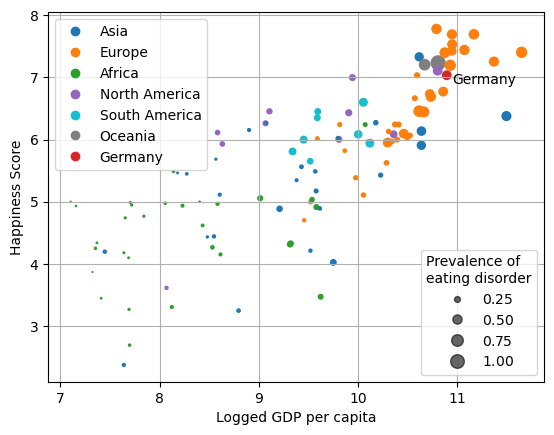

In [100]:
from matplotlib.colors import ListedColormap
classes = ["Asia","Europe","Africa","North America","South America","Oceania", "Germany"]
colors = ListedColormap(["tab:blue","tab:orange","tab:green","tab:purple","tab:cyan", "tab:gray", "tab:red"])

fig, ax = plt.subplots()
s, slope, bias =linear_inc(s,2,100)

scatter = ax.scatter(x,y,s=s, c=v,cmap=colors)
plt.xlabel("Logged GDP per capita")
plt.ylabel("Happiness Score")
plt.grid()

plt.text(10.95, 6.9, "Germany")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
kw = dict(prop="sizes", num=4, alpha=0.6, func=lambda s: (s-bias)/slope)
legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Prevalence of\neating disorder")

plt.savefig("scatter_Happiness_gdp_eating.pdf")